In [1]:
import pandas as pd
import pandas_profiling

In [2]:
df = pd.read_csv("../data/nbu_project_utf8.csv")
df["type"] = df["type"].map({1:0, 0:1})

In [3]:
df.head()

,id,name,type,Грошові кошти та їх еквіваленти,Кошти обов’язкових резервів банку в НБУ,Торгові цінні папери,"Інші фінансові активи, що обліковуються за справедливою вартістю через прибуток або збиток","Кошти в інших банках, усього","кредити та заборгованість юридичних осіб, усього","кредити та заборгованість фізичних осіб, усього",...,Прибуток/(збиток) до оподаткування,Витрати на податок на прибуток,Прибуток/(збиток),Переоцінка цінних паперів у портфелі банку на продаж,Переоцінка основних засобів та нематеріальних активів,Результат переоцінки за операціями з хеджування грошових потоків,Частка іншого сукупного прибутку асоційованої компанії,"Податок на прибуток, пов'язаний з іншим сукупним доходом",Інший сукупний дохід після оподаткування,Усього сукупного доходу
0,1,АВАНГАРД,0,4.664548e+04,0.0,0.000,0.0,340227.400,0.00,0.00,...,18137.2900,-3778.200,14359.0900,1450.084,0.0,0,0,-261.00,1189.084,15548.1800
1,2,АГРОКОМБАНК (Айбокс Банк),0,9.484721e+04,0.0,43204.790,0.0,102442.100,252253.20,60538.96,...,499.4128,-200.000,299.4128,0.000,0.0,0,0,0.00,0.000,299.4128
2,3,АКОРДБАНК,0,9.479980e+04,0.0,0.000,0.0,5769.872,392938.90,13099.39,...,4837.4000,0.000,4837.4000,-126.803,0.0,0,0,0.00,-126.803,4710.5980
3,4,АКЦЕНТ (А-Банк),0,1.179334e+06,0.0,7540.334,0.0,0.000,149406.40,781868.00,...,14573.0100,-3955.850,10617.1600,0.000,0.0,0,0,0.00,0.000,10617.1600
4,5,АЛЬПАРІ БАНК,0,8.391882e+02,0.0,0.000,0.0,0.000,27213.97,0.00,...,531.2683,-297.416,233.8520,9508.093,0.0,0,0,-1905.66,7602.434,7836.2860


In [4]:
pandas_profiling.ProfileReport(df)

Number of variables,70
Number of observations,157
Total Missing (%),0.0%
Total size in memory,85.9 KiB
Average record size in memory,560.5 B
Numeric,51
Categorical,0
Date,0
Text (Unique),1
Rejected,18
Distinct count,157


In [5]:
from sklearn.manifold import TSNE
import numpy as np

In [6]:
model = TSNE(n_components=2, perplexity=70, random_state=0)
np.set_printoptions(suppress=True)
new_df = model.fit_transform(df.iloc[:,3:]) 

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects

%matplotlib inline

In [8]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

#     # We add the labels for each digit.
#     txts = []
#     for i in range(2):
#         # Position of each label.
#         xtext, ytext = np.median(x[colors == i, :], axis=0)
#         txt = ax.text(xtext, ytext, str(i), fontsize=24)
#         txt.set_path_effects([
#             PathEffects.Stroke(linewidth=5, foreground="w"),
#             PathEffects.Normal()])
#         txts.append(txt)

    return f, ax, sc

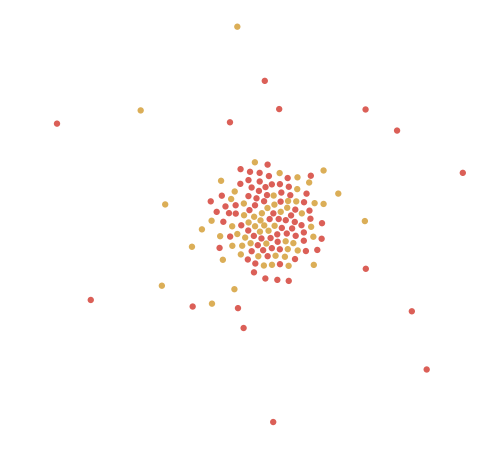

In [9]:
scatter(new_df, df["type"]);

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score

In [11]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

In [12]:
train_cols = df.columns[3:]
target_col = "type"
lr = LogisticRegressionCV(Cs=[0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], cv=skf,
                          scoring="f1", n_jobs=-1, random_state=1, refit=True)
lr.fit(df[train_cols], df[target_col])

LogisticRegressionCV(Cs=[1e-05, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
           class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=1, refit=True, scoring='f1', solver='lbfgs',
           tol=0.0001, verbose=0)

In [13]:
lr.scores_[1].mean(axis=0)

array([ 0.62893773,  0.67173913,  0.65892531,  0.65159563,  0.64523361,
        0.62055507,  0.62769963,  0.63942857,  0.62274762])

In [14]:
df["type"].value_counts()

0    93
1    64
Name: type, dtype: int64

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
scores = []
for train, val in skf.split(df, df["type"]):
    dt = DecisionTreeClassifier(min_samples_leaf=2)
    dt.fit(df.loc[train, train_cols], df.loc[train, target_col])
    predictions = dt.predict(df.loc[val, train_cols])
    scores.append(f1_score(df.loc[val, target_col], predictions))

In [17]:
scores

[0.5185185185185186,
 0.48275862068965519,
 0.44444444444444448,
 0.61538461538461542,
 0.28571428571428575]

In [18]:
from sklearn.ensemble import RandomForestClassifier
scores = []
for train, val in skf.split(df, df["type"]):
    dt = RandomForestClassifier(n_estimators=100, max_depth=7)
    dt.fit(df.loc[train, train_cols], df.loc[train, target_col])
    predictions = dt.predict(df.loc[val, train_cols])
    scores.append(f1_score(df.loc[val, target_col], predictions))

In [19]:
scores

[0.52631578947368418, 0.54545454545454553, 0.43478260869565222, 0.5, 0.125]

In [20]:
import xgboost as xgb

In [21]:
def f1(preds, dtrain):
    from sklearn.metrics import f1_score
    labels = dtrain.get_label()
    preds = np.array((preds > 0.5), "int8")
    return 'F1-score', f1_score(labels, preds)

params = {
    'objective': "binary:logistic",
    'max_depth': 5,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'subsample': 0.4,
    'silent': 1
}

xgb_train = xgb.DMatrix(df[train_cols], label=df[target_col], feature_names=train_cols)
xgb.cv(params, xgb_train, 1000, folds=skf, metrics=(), feval=f1, maximize=False, 
       verbose_eval=False, early_stopping_rounds=20)

,test-F1-score-mean,test-F1-score-std,test-error-mean,test-error-std,train-F1-score-mean,train-F1-score-std,train-error-mean,train-error-std
0,0.515626,0.022898,0.452104,0.034324,0.590039,0.064431,0.334218,0.045577
1,0.469444,0.061739,0.413522,0.059352,0.577993,0.169458,0.289652,0.058228
2,0.496633,0.041306,0.407353,0.032157,0.649262,0.148292,0.248168,0.065811
3,0.464670,0.104618,0.381713,0.068904,0.635053,0.142158,0.251343,0.065477
4,0.496078,0.076897,0.362845,0.023604,0.672650,0.126594,0.225916,0.058838
5,0.554514,0.071642,0.343856,0.025726,0.721753,0.132388,0.190873,0.063236
6,0.494306,0.058506,0.381833,0.043743,0.671499,0.126757,0.222802,0.064852
7,0.487712,0.019050,0.375302,0.055380,0.733968,0.075318,0.187790,0.042433
8,0.484710,0.062359,0.388123,0.051461,0.743430,0.077093,0.181410,0.040726
9,0.542980,0.043190,0.336962,0.068589,0.751316,0.094538,0.171856,0.053575
